In [50]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import pandas as pd
import pylab
import scipy as sp
import scipy.stats

from datetime import datetime
from matplotlib.ticker import MultipleLocator
from numpy import array, polyfit, poly1d
from pandas import DataFrame, to_datetime
from pandas.plotting import register_matplotlib_converters
from scipy.stats import norm,rayleigh
from tkinter import *
from tkinter import filedialog

register_matplotlib_converters()

%matplotlib inline

In [51]:
def get_PRIM_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data", title = "Select PRIM master file",\
                        filetypes = (("Prim files","*.Prim"),("Prim files","*.prim"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [52]:
def get_SECO_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data", title = "Select SECO master file",\
                        filetypes = (("Seco files","*.Seco"),("Seco files","*.seco"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [53]:
def get_DSECO_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data\Master_files", title = "Select DSECO master file",\
                        filetypes = (("Dseco files","*.CORRECTED"),("Dseco files","*.corrected"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [54]:
def Get_Prim_records():
    PRIM_rectype = np.dtype([
        ('Procid','B', (12,)),
        ('Loc','i'),
        ('date_val','i2',(12)),
        ('Hsig','f'), ('Thsig','f'), ('Hrms', 'f'), ('Hmax', 'f'),('Tc', 'f'),('Tz', 'f'), ('H10', 'f'), 
        ('Th10', 'f'), ('Thmax', 'f'), ('Tzmax', 'f'), ('Hm0', 'f'),('T02', 'f'),('Tp', 'f'), ('EPS', 'f'), 
        ('Npts', 'i'),
        ('Param2','f', (4,))])

# Get name of input PRIM file
    Input_Prim_File = get_PRIM_file()

    # Open file
    f = open(Input_Prim_File)
    print('Getting PRIM data')

    # Read data from the Binary file into a DF based on the structure in the DT
    data = np.fromfile(f, PRIM_rectype)
    PRIM_recs = DataFrame.from_records(np.array(data).tolist())

    PRIM_recs.columns = ['Procid','Loc','date_val','Hsig','Thsig','Hrms','Hmax','Tc','Tz',
                    'H10','Th10','Thmax','Tzmax','Hm0','T02','Tp','EPS','Npts','Param2']

    # Remove errant zero's from data
    PRIM_recs = PRIM_recs.loc[PRIM_recs.date_val.apply(lambda x: x[0])!=0]

    # Convert date/time column data into Dates and times
    Record_time = pd.DataFrame(PRIM_recs.date_val.values.tolist(), \
            columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

    Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

    # Insert Date column at start of DF
    PRIM_recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    # Remove unwanted columns from the DF
    PRIM_recs = PRIM_recs.drop(columns=[
        'Procid',
        'Loc',
        'date_val',
        'Param2'], axis=1)

    return(PRIM_recs)

In [55]:
def Get_Seco_records():
    # Create a DT based on the structure type of the SECO Master File

    SECO_rectype = np.dtype([('Loc','i'),
    #                    ('Year','i'),('Month','i'),('Day', 'i'),('Hour', 'i'),('Min', 'i'), ('Sec','i'),
                        ('date_val','i2',(12)),
                        ('Spc', 'f', (60,))
                       ])

    # Get name of input SECO file
    Input_Seco_File = get_SECO_file()

    # Open file
    f = open(Input_Seco_File)
    print('Getting SECO data')
    
    # Read data from the Binary file into a DF based on the structure in the DT
    data = np.fromfile(f, SECO_rectype)
    SECO_recs = DataFrame.from_records(np.array(data).tolist())

    SECO_recs.columns = ['Loc','date_val','Spc']

    # Remove errant zero's from data
    SECO_recs = SECO_recs.loc[SECO_recs.date_val.apply(lambda x: x[0])!=0]


    # Convert date/time column data into Dates and times
    Record_time = pd.DataFrame(SECO_recs.date_val.values.tolist(), \
            columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

    Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

    # Insert Date column at start of DF
    SECO_recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    SECO_recs = SECO_recs.drop(['Loc', 'date_val'], axis=1)

    return(SECO_recs)

In [56]:
def Get_Dseco_records():
    # Create a DT based on the structure type of the DSECO Master File
    rectype = np.dtype([
                        ('Procid','B',(12,)),
                        ('Loc','i'),
                        ('date_val','i2',(12)),
                        ('Elapse','i2',(2)),
                        ('Hm0','f'),('T02','f'),('Pdens','f'),('Temp','f'),
                        ('Vacc','f'),('Xacc','f'),('Yacc','f'),
                        ('Orient','f'),('Inclin','f'),
                        ('Tp_buoy','f'),('Avg_dir','f'),('Peak_dir','f'),
                        ('Corr_to_True','f'),
                        ('jdirn', 'i2', (64)),('jrpower', 'i2', (64)),('jspread', 'i2', (64)),                     
                       ])

    # Get name of input DSECO file
    Input_DSECO_File = get_DSECO_file()

    # Open file
    f = open(Input_DSECO_File)
    print('Getting DSECO data')

    # Read data from the Binary file into a DF based on the structure in the DT
    data = np.fromfile(f, rectype)
    DSECO_recs = DataFrame.from_records(np.array(data).tolist())

    DSECO_recs.columns = ['Procid','Loc','date_val','Elapse',
                            'Hm0','T02','Pdens','Temp',
                            'Vacc','Xacc','Yacc',
                            'Orient','Inclin',
                            'Tp_buoy','Avg_dir','Peak_dir',
                            'Corr_to_True','jdirn','jrpower','jspread']

    # Locate and remove errant zero's from data
    zero_data = DSECO_recs.loc[DSECO_recs.date_val.apply(lambda x: x[0])==0].index

    if len(zero_data) > 0:
        DSECO_recs_zero = DSECO_recs    # make a copy to locate where the zeros occur
        date_string =  [[DSECO_recs.loc[zero_data[0]-1].date_val.tolist()][0][i] for i in range(0,10,2)]
        ' '.join(str(p) for p in [date_string])
        first_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
            +':'+str(date_string[4])
        date_string =  [[DSECO_recs.loc[zero_data[-1]+1].date_val.tolist()][0][i] for i in range(0,10,2)]
        ' '.join(str(p) for p in [date_string])
        last_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
            +':'+str(date_string[4])
        print('Alert: ',len(zero_data),' Zero\'s found (and removed) between ',first_val,' and ',last_val)

        DSECO_recs = DSECO_recs.loc[DSECO_recs.date_val.apply(lambda x: x[0])!=0]    # remove the zeros from the df

    # Convert date/time column data into Dates and times
    Record_time = pd.DataFrame(DSECO_recs.date_val.values.tolist(), \
            columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

    # Correct dates for two-digit year 
    Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

    # Insert Date column at start of DF
    DSECO_recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    # Insert Date column at start of DF
    DSECO_recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    DSECO_recs = DSECO_recs.drop(['Loc', 'date_val'], axis=1)

    return(DSECO_recs)

In [57]:
def calc_RTWS_moments(f,Spectra):
# calculate m0, m1, m2, m4 from spectra    

    f = np.asarray(f)
    
    f1 = f[0]; f2 = f[-1]
    
    # calculation of the spectral moments    
    ind_f = np.where((f >= f1) & (f <= f2))[0]   
    
    m0 = np.trapz(Spectra[ind_f]*f[ind_f]**0,f[ind_f])
    m1 = np.trapz(Spectra[ind_f]*f[ind_f]**1,f[ind_f])           
    m2 = np.trapz(Spectra[ind_f]*f[ind_f]**2,f[ind_f])           
    m4 = np.trapz(Spectra[ind_f]*f[ind_f]**4,f[ind_f])           
    
    return m0,m1,m2,m4

def get_RTWS_parameters(f,Spectra):
    m0,m1,m2,m4 = calc_RTWS_moments(f,Spectra)    
    
# calc wave parameters Hm0, Hrms, T01, T02, Tc
    Hm0 = 4*np.sqrt(m0);     # Tucker & Pitt p.32 (2.2-6b)
    Hrms = np.sqrt(8*Hm0)    # Goda 2nd. Edition p.262 (9.15)
    T01 = m0/m1;             # Tucker & Pitt p.41 Table 2.2 
    T02 = np.sqrt(m0/m2);    # Tucker & Pitt p.40 (2.3-2)
    Tc = np.sqrt(m2/m4)      # Tucker & Pitt p.41 Table 2.2 - also see Notes
    
    # identify spectral peak and frequency at peak    
    max_frequency = [k for k, j in enumerate(Spectra) if j == np.max(Spectra)]
    Fp = f[max_frequency[0]]; Tp = 1/Fp 

    return(Hm0,Hrms,T01,T02,Tc,Tp)   # get_RTWS_parameters()

In [58]:
def calc_Mk3_moments(f_Mk3, Spectra):
# routine to calculate the spectral moments: m0; m1; m2; and m4 from an input Mk3 spectra
    
    Ax1 = (f_Mk3[15] - f_Mk3[0]) / 15
    Ax2 = (f_Mk3[63] - f_Mk3[15]) / 32

# calc spectral moments m0, m1,m2,and m4
    s00 = 0; s10 = 0; s20 = 0; m0 = 0
    s01 = 0; s11 = 0; s21 = 0; m1 = 0
    s02 = 0; s12 = 0; s22 = 0; m2 = 0
    for __ in range(1,13):
        s00 += Spectra[__]
        s01 += f_Mk3[__] * Spectra[__]
        s02 += f_Mk3[__]**2 * Spectra[__]
    m0 = 0.5*Ax1*(Spectra[0] + 2*s00 + Spectra[15])
    m1 = 0.5*Ax1*(f_Mk3[0]*Spectra[0]+2*s01+f_Mk3[15]*Spectra[15])
    m2 = 0.5*Ax1*(f_Mk3[0]**2*Spectra[0]+2*s02+f_Mk3[15]**2*Spectra[15])
    m4 = 0.5*Ax1*(f_Mk3[0]**2*Spectra[0]+2*s02+f_Mk3[15]**2*Spectra[15])
    
    for __ in range(16,61):
        s10 += Spectra[__]
        s11 += f_Mk3[__] * Spectra[__]
        s12 += f_Mk3[__]**2 * Spectra[__]
    m0 += 0.5*Ax2*(Spectra[15] + 2*s10 + Spectra[63])
    m1 += 0.5*Ax2*(f_Mk3[15]*Spectra[15]+2*s11+f_Mk3[63]*Spectra[63])
    m2 += 0.5*Ax2*(f_Mk3[15]**2*Spectra[15]+2*s12+f_Mk3[63]**2*Spectra[63])
    m4 += 0.5*Ax2*(f_Mk3[15]**4*Spectra[15]+2*s12+f_Mk3[63]**2*Spectra[63])
    
    
    return (m0,m1,m2,m4)   # Mk_3_moments()

def get_Mk3_parameters(f,Spectra):
    m0,m1,m2,m4 = calc_Mk3_moments(f,Spectra)    
    
# calc wave parameters Hm0, Hrms, T01, T02, Tc
    Hm0 = 4*np.sqrt(m0);     # Tucker & Pitt p.32 (2.2-6b)
    Hrms = np.sqrt(8*Hm0)    # Goda 2nd. Edition p.262 (9.15)
    T01 = m0/m1;             # Tucker & Pitt p.41 Table 2.2 
    T02 = np.sqrt(m0/m2);    # Tucker & Pitt p.40 (2.3-2)
    Tc = np.sqrt(m2/m4)      # Tucker & Pitt p.41 Table 2.2 - also see Notes
    
    # identify spectral peak and frequency at peak    
    max_frequency = [k for k, j in enumerate(Spectra) if j == np.max(Spectra)]
    Fp = f[max_frequency[0]]; Tp = 1/Fp 

    return(Hm0,Hrms,T01,T02,Tc,Tp)   # get_Mk3_parameters()

In [59]:
def Get_SECO_parameters(SECO_recs):
    freq = []
    for i in range(60): freq.append(0.025+i*0.01)

    Parameter_list = []

    print('Calculating "Hm0" "Hrms" "T01" "T02" "Tc" "Tp" from Spectral ordinates!')
    print('Note - this will take a few minutes.')
    for i in range(len(SECO_recs)):
        Parameter_list.append(list(get_parameters_Banded(freq,SECO_recs.iloc[i].Spc)))

    SECO_parameter_df = pd.DataFrame.from_records(Parameter_list)    
    SECO_parameter_df.rename(columns={0: 'Hm0', 1: 'Hrms', 2: 'T01', 3: 'T02',4: 'Tc', 5: 'Tp'}, inplace=True)
    SECO_parameter_df.index = SECO_recs.index
    
    return(SECO_parameter_df)

In [111]:
#######################################
#               MAIN
#######################################

PRIM_recs = Get_Prim_records()
SECO_recs = Get_Seco_records()
DSECO_recs = Get_Dseco_records()

df_SECO_DSECO = pd.merge(SECO_recs,DSECO_recs, left_index=True, right_index=True)

##Parameter_df = Get_SECO_parameters(SECO_recs)

##plt.figure(figsize=(20, 10))
##plt.plot(PRIM_recs.Hm0,PRIM_recs.T02/PRIM_recs.Hm0,marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'lightblue')
##plt.plot(Parameter_df.Hm0,Parameter_df.T02/Parameter_df.Hm0,marker='o',lw=0,mec='b',mew=0.3,ms = 3, c = 'yellow',alpha=0.5)
##plt.legend()
##plt.show()

Getting PRIM data
Getting SECO data
Getting DSECO data


In [12]:
# Merge the SECO and DSECO DF's
df_SECO_DSECO = pd.merge(SECO_recs,DSECO_recs, left_index=True, right_index=True)

Data available between  1996-07-24 18:00:00  and  2019-05-31 23:30:00
Enter a date to view Spectra (i.e. YYYY MM DD) 2007 5 1
Data available between  1996-07-24 18:00:00  and  2019-05-31 23:30:00
Enter a date to view Spectra (i.e. YYYY MM DD) 2007 5 6
2007-05-06T03:00:00.000000000


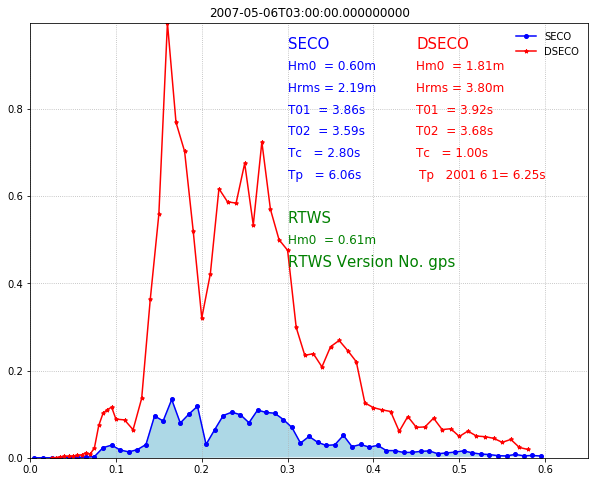

In [ ]:
def close():
    global lb, master, item1
    try:
        item1 = lb.get(lb.curselection())
    except:
        item1 = 'Nothing selected'
    master.destroy()
    return(item1)

# Display range of available dates, and request user to enter date to view
print('Data available between ',df_SECO_DSECO.index[0],' and ',df_SECO_DSECO.index[-1])
date_entry = input('Enter a date to view Spectra (i.e. YYYY MM DD) ')
year, month, day = map(int, date_entry.split(' '))
date = datetime(year, month, day)

# try to find the selected date
try:
    start_date = df_SECO_DSECO.loc[df_SECO_DSECO.index.values==np.datetime64(date)]
    end_date = df_SECO_DSECO.loc[df_SECO_DSECO.index.values==np.datetime64(date) + np.timedelta64(1,'D')]
    records = df_SECO_DSECO.loc[start_date.index.values[0]:end_date.index.values[0]]
    
    freq_DSECO = []
    for i in range(64):
                if i<16:
                    freq_DSECO.append(0.025+i*0.005) 
                else:
                    freq_DSECO.append(0.11+(i-16)*0.01)

    # Calc freuqencies for SECO spectra Vide L&T RTWS Analysis Package - August 1998 (Man6\#1294-V7.00) p.41
    freq_SECO = []
    for ii in range(60):
                freq_SECO.append(0.005+ii*0.01) 

    item1 = ''                
except:
    print("Can't find ", date)

def close():
    global lb, master, item1
    try:
        item1 = lb.get(lb.curselection())
    except:
        item1 = 'Nothing selected'
    master.destroy()
    return(item1)

# Display range of available dates, and request user to enter date to view
print('Data available between ',df_SECO_DSECO.index[0],' and ',df_SECO_DSECO.index[-1])
date_entry = input('Enter a date to view Spectra (i.e. YYYY MM DD) ')
year, month, day = map(int, date_entry.split(' '))
date = datetime(year, month, day)

# try to find the selected date
try:
    start_date = df_SECO_DSECO.loc[df_SECO_DSECO.index.values==np.datetime64(date)]
    end_date = df_SECO_DSECO.loc[df_SECO_DSECO.index.values==np.datetime64(date) + np.timedelta64(1,'D')]
    records = df_SECO_DSECO.loc[start_date.index.values[0]:end_date.index.values[0]]
    
    freq_DSECO = []
    for i in range(64):
                if i<16:
                    freq_DSECO.append(0.025+i*0.005) 
                else:
                    freq_DSECO.append(0.11+(i-16)*0.01)

    # Calc freuqencies for SECO spectra Vide L&T RTWS Analysis Package - August 1998 (Man6\#1294-V7.00) p.41
    freq_SECO = []
    for ii in range(60):
                freq_SECO.append(0.005+ii*0.01) 

    item1 = ''                
except:
    print("Can't find ", date)

while item1 != 'EXIT':
    master = Tk()   
    master.title("SELECT DATE/TIME")

    scrollbar = Scrollbar(master, orient="vertical")
    lb = Listbox(master, width=30, height=50, font=('Aerial',10),justify='center',yscrollcommand=scrollbar.set)
    scrollbar.config(command=lb.yview)

    scrollbar.pack(side="right", fill="y")
    lb.pack(side="left",fill="both", expand=True)

    lb.insert('end', 'EXIT')
    for item in records.index.values:
        lb.insert('end', item)
    lb.insert('end', 'EXIT')
    lb.focus()

    b = Button(master, text = "OK", command = close).pack()

    try:
        master.mainloop()

    except:
        pass

    if (item1 != 'EXIT'):
        print(item1)
        aa = item1
        
        # Get the RTWS version number from the ProcID binary string and remove null characters
        Version = ''.join(chr(i) for i in df_SECO_DSECO.iloc[np.where(df_SECO_DSECO.index==item1)[0].astype('int')[0]].Procid)
        Version = re.sub(r'[^ -~].*', '', Version)

                
#        try:
        SECO_power = df_SECO_DSECO.loc[item1].Spc
        DSECO_power = np.exp(-df_SECO_DSECO.loc[item1].jrpower/200.)*df_SECO_DSECO.loc[item1].Pdens

        SECO_Hm0,SECO_Hrms,SECO_T01,SECO_T02,SECO_Tc,SECO_Tp = get_RTWS_parameters(freq_SECO,SECO_power)
        DSECO_Hm0,DSECO_Hrms,DSECO_T01,DSECO_T02,DSECO_Tc,DSECO_Tp = get_Mk3_parameters(freq_DSECO,DSECO_power)

        plt.figure(figsize=(10,8))
        item1 = aa
        plt.title(item1,fontsize=12)

        plt.plot(freq_SECO,SECO_power,color='b',marker='o',markersize=4,label='SECO')
        plt.fill(freq_SECO,SECO_power,c='lightblue')

        plt.plot(freq_DSECO,DSECO_power,c='r',marker='*',markersize=4,label='DSECO')
        #fig.tight_layout() 
        plt.grid(True,axis='both',linestyle=':')
        plt.xlim(0,0.65)
        y_max = max(max(SECO_power),max(DSECO_power))
        plt.ylim(0,y_max)

        plt.text(0.3, y_max*0.95, 'SECO',horizontalalignment='left',verticalalignment='center',color='b',fontsize=15)
        plt.text(0.3, y_max*0.90, 'Hm0  = '+"%.2f" % SECO_Hm0+'m',horizontalalignment='left',verticalalignment='center',color='b',fontsize=12)
        plt.text(0.3, y_max*0.85, 'Hrms = '+"%.2f" % SECO_Hrms+'m',horizontalalignment='left',verticalalignment='center',color='b',fontsize=12)
        plt.text(0.3, y_max*0.80, 'T01  = '+"%.2f" % SECO_T01+'s',horizontalalignment='left',verticalalignment='center',color='b',fontsize=12)
        plt.text(0.3, y_max*0.75, 'T02  = '+"%.2f" % SECO_T02+'s',horizontalalignment='left',verticalalignment='center',color='b',fontsize=12)
        plt.text(0.3, y_max*0.70, 'Tc   = '+"%.2f" % SECO_Tc+'s',horizontalalignment='left',verticalalignment='center',color='b',fontsize=12)
        plt.text(0.3, y_max*0.65, 'Tp   = '+"%.2f" % SECO_Tp+'s',horizontalalignment='left',verticalalignment='center',color='b',fontsize=12)

        plt.text(0.45, y_max*0.95, "DSECO",horizontalalignment='left',verticalalignment='center',color='r',fontsize=15)
        plt.text(0.45, y_max*0.90, 'Hm0  = '+"%.2f" % DSECO_Hm0+'m',horizontalalignment='left',verticalalignment='center',color='r',fontsize=12)
        plt.text(0.45, y_max*0.85, 'Hrms = '+"%.2f" % DSECO_Hrms+'m',horizontalalignment='left',verticalalignment='center',color='r',fontsize=12)
        plt.text(0.45, y_max*0.80, 'T01  = '+"%.2f" % DSECO_T01+'s',horizontalalignment='left',verticalalignment='center',color='r',fontsize=12)
        plt.text(0.45, y_max*0.75, 'T02  = '+"%.2f" % DSECO_T02+'s',horizontalalignment='left',verticalalignment='center',color='r',fontsize=12)
        plt.text(0.45, y_max*0.70, 'Tc   = '+"%.2f" % DSECO_Tc+'s',horizontalalignment='left',verticalalignment='center',color='r',fontsize=12)
        plt.text(0.453, y_max*0.65, 'Tp   2001 6 1= '+"%.2f" % DSECO_Tp+'s',horizontalalignment='left',verticalalignment='center',color='r',fontsize=12)

        plt.text(0.3, y_max*0.55, 'RTWS',horizontalalignment='left',verticalalignment='center',color='g',fontsize=15)
        plt.text(0.3, y_max*0.50, 'Hm0  = '+"%.2f" % df_SECO_DSECO.loc[item1].Hm0+'m',horizontalalignment='left',verticalalignment='center',color='g',fontsize=12)
        plt.text(0.3, y_max*0.45, 'RTWS Version No. '+Version,horizontalalignment='left',verticalalignment='center',color='g',fontsize=15)
        
        plt.legend(frameon=False)
        plt.show()
#        except:
#            print('ALERT: Can not display record!')
        
    else:
        print('Program terminated by user')

In [81]:
Old_Version = ''
for ii in range(len(df_SECO_DSECO)):
    Version = ''.join(chr(i) for i in df_SECO_DSECO.iloc[ii].Procid)
    Version = re.sub(r'[^ -~].*', '', Version)
    if Version != Old_Version:
        print(df_SECO_DSECO.index[ii],Version)
    Old_Version = Version

2008-11-25 11:30:00 gps         


In [47]:
df_SECO_DSECO.index[24]

Timestamp('1995-01-14 14:00:00')

In [63]:
Dseco_recs

NameError: name 'Dseco_recs' is not defined